In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

from cel.cf_methods import CCHVAE
from cel.cf_methods.local.c_chvae.mlmodel import CustomMLModel
from cel.datasets.file_dataset import FileDataset
from cel.datasets.preprocess_datasets.preprocess_moons import (
    transform_moons,
)
from cel.metrics.metrics import evaluate_cf
from cel.models import LogisticRegression, MaskedAutoregressiveFlow

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Prepare the data

dataset = FileDataset(config_path="../config/datasets/moons.yaml")
# dataset = AdultDataset()

dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test = transform_moons(
    dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test
)


train_dataset = TensorDataset(
    torch.tensor(dataset.X_train, dtype=torch.float32),
    torch.tensor(dataset.y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(dataset.X_test, dtype=torch.float32),
    torch.tensor(dataset.y_test, dtype=torch.float32),
)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [4]:
# Train a discriminative model
num_inputs = dataset.X_train.shape[1]
num_targets = 1

discriminative_model = LogisticRegression(
    num_inputs=num_inputs,
    num_targets=num_targets,
)
discriminative_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=600, lr=0.01)

Epoch 3365, Train: 0.2590, test: 0.2769, patience: 600:  34%|███▎      | 3365/10000 [00:12<00:24, 274.46it/s]


In [5]:
# Train a generative model
num_inputs = dataset.X_train.shape[1]
num_targets = 1

generative_model = MaskedAutoregressiveFlow(
    features=num_inputs,
    hidden_features=128,
    context_features=num_targets,
)
generative_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=600, lr=0.01)

Epoch 1393, Train: -1.3796, test: -1.2790, patience: 600:  14%|█▍        | 1393/10000 [00:27<02:49, 50.92it/s]


In [6]:
log_prob_threshold = np.median(generative_model.predict_log_prob(test_dataloader))

In [8]:
dataset.y_train = discriminative_model.predict(dataset.X_train)
dataset.y_test = discriminative_model.predict(dataset.X_test)

In [9]:
import pandas as pd

from cel.cf_methods.local.c_chvae.data import CustomData

custom_dataset = CustomData(dataset)
wrapped_model = CustomMLModel(discriminative_model, custom_dataset)

input_size = dataset.X_train.shape[1]

cf_method = CCHVAE(
    mlmodel=wrapped_model,
    hyperparams={
        "data_name": "moons",
        "vae_params": {"layers": [input_size, 64, 32, 16]},
    },
)
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test != target_class]
y_test_origin = dataset.y_test[dataset.y_test != target_class]

factuals = pd.DataFrame(X_test_origin, columns=wrapped_model.feature_input_order)
results = cf_method.get_counterfactuals_without_check(factuals)

2025-10-13 16:28:53,623 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - Start training of Variational Autoencoder...
2025-10-13 16:28:53,645 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [Epoch: 0/5] [objective: 44.413]
2025-10-13 16:28:53,646 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.41]
2025-10-13 16:28:53,665 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.38]
2025-10-13 16:28:53,684 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.23]
2025-10-13 16:28:53,702 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.24]
2025-10-13 16:28:53,721 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.32]
2025-10-13 16:28:53,724 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - ... finished training of Variational Autoencoder.


In [10]:
results

,0,1
0,0.508015,0.491635
1,0.502230,0.484994
2,0.502755,0.488071
3,0.507004,0.491674
4,0.504909,0.483672
...,...,...
96,0.506519,0.490389
97,0.510496,0.488894
98,0.513231,0.485757
99,0.504324,0.489620


In [11]:
results_arr = results.to_numpy()
ys_target = np.abs(1 - y_test_origin)

dataset.raw_data.columns = [0, 1, 2]

evaluate_cf(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=results_arr,
    model_returned=np.ones_like(results_arr),
    continuous_features=[0, 1],
    categorical_features=[],
    median_log_prob=log_prob_threshold,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    y_target=ys_target,
    metrics_conf_path="../cel/pipelines/conf/metrics/default.yaml",
)

2025-10-13 16:28:54,337 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 101 counterfactuals, 101 valid


{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 0.33355750600176465,
 'proximity_categorical_jaccard': 0.33355750600176465,
 'proximity_continuous_manhattan': 0.4222513997044396,
 'proximity_continuous_euclidean': 0.33355750600176465,
 'proximity_continuous_mad': 2.300625202679398,
 'proximity_l2_jaccard': 0.33355750600176465,
 'proximity_mad_hamming': 2.300625202679398,
 'prob_plausibility': 0.0,
 'log_density_cf': -3.6643484,
 'log_density_test': -0.6062279,
 'lof_scores_cf': 1.6590836,
 'lof_scores_test': 1.062591,
 'isolation_forest_scores_cf': 0.028786353703396515,
 'isolation_forest_scores_test': 0.005029776356548851}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


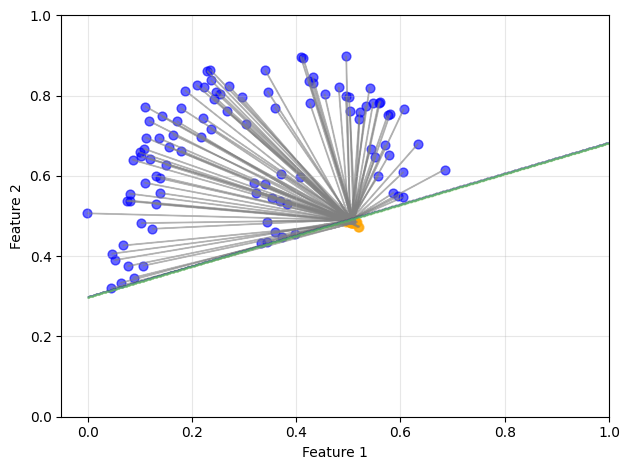

In [12]:
from cel.plotting.counterfactual_visualization import plot_counterfactuals

plot_counterfactuals(X_test_origin, results_arr, None, discriminative_model)